<a href="https://colab.research.google.com/github/wrymp/Final-Project-Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip /content/walmart-recruiting-store-sales-forecasting.zip
! unzip /content/train.csv.zip
! unzip /content/test.csv.zip
! unzip /content/features.csv.zip
! unzip /content/sampleSubmission.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.3 MB/s eta 0:00:00
Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 419MB/s]
Archive:  /content/walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/features.csv.zip
  inflating: features.csv            
Archive:  /content/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


Using device: cuda
PyTorch version: 2.6.0+cu124
CUDA device: Tesla T4
CUDA memory: 14.7GB


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (dshan21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


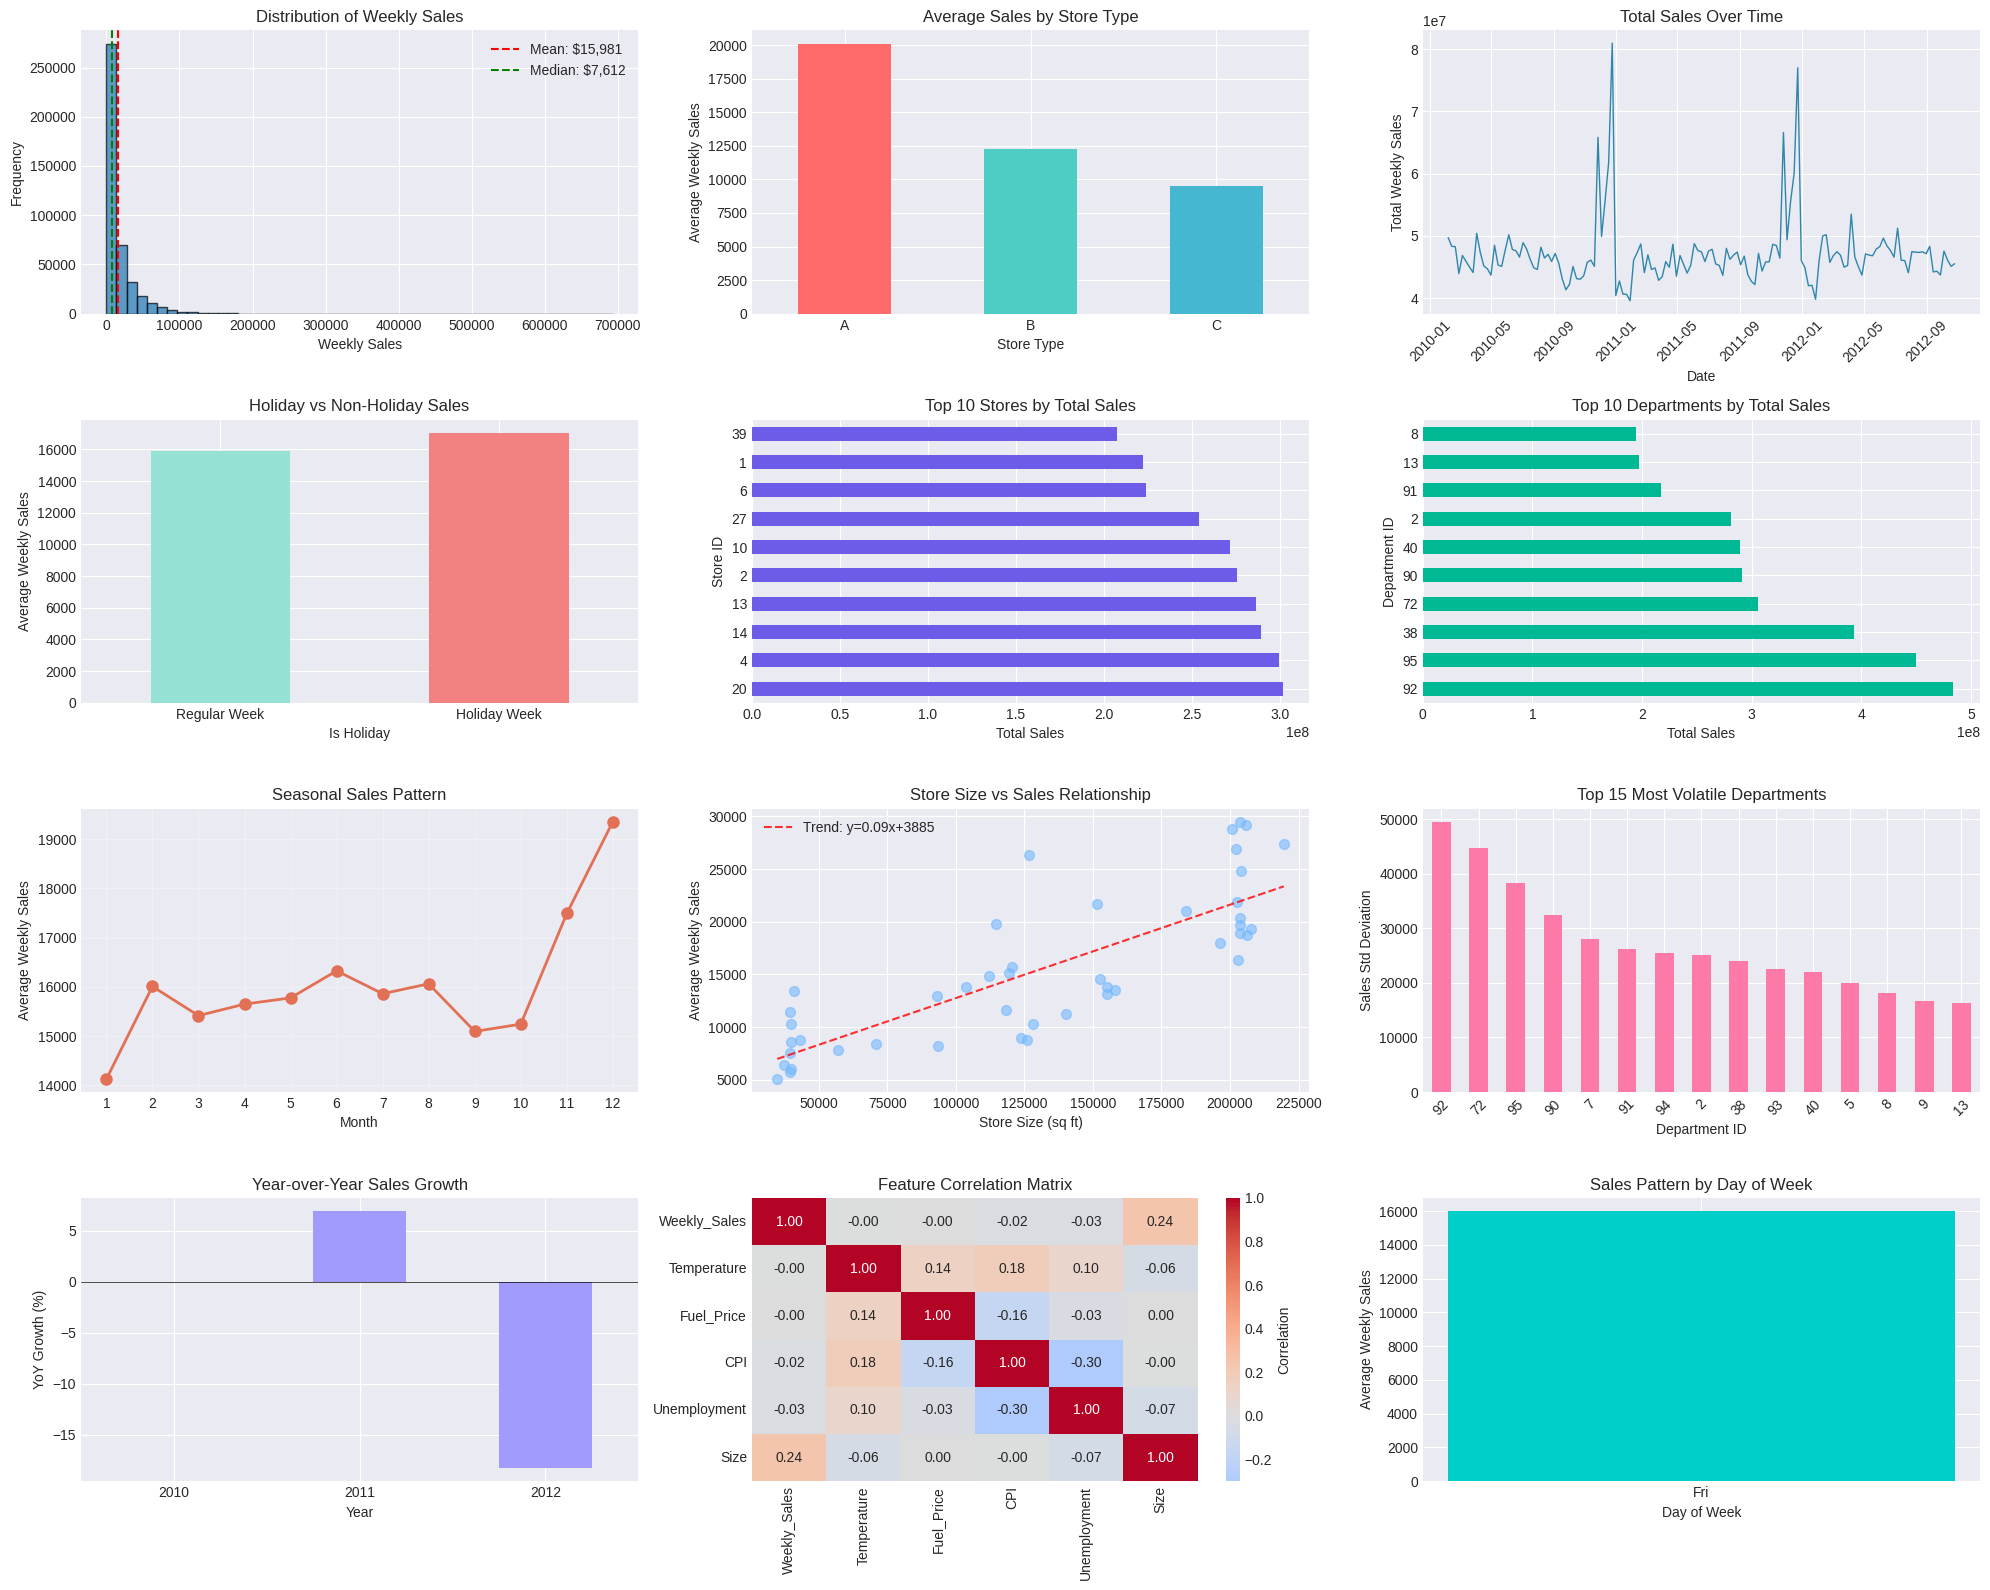


ENHANCED PATCHTST IMPLEMENTATION READY

Features implemented:
✓ Comprehensive feature engineering
✓ Advanced data analysis and visualization
✓ Enhanced PatchTST architecture
✓ Training with detailed metrics
✓ Feature importance analysis
✓ Complete evaluation pipeline

Ready for training with improved features and visualizations!


In [3]:
"""
Enhanced PatchTST Implementation for Walmart Sales Forecasting
===============================================================
Complete implementation with advanced feature engineering, data analysis, and visualizations
"""

# %% [markdown]
# # Enhanced PatchTST for Walmart Sales Forecasting
#
# This notebook implements an enhanced PatchTST (Patch Time Series Transformer) with:
# - Comprehensive feature engineering
# - Detailed data analysis and visualization
# - Advanced time series features
# - Complete evaluation metrics and graphs

# %% Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb
import warnings
from datetime import datetime, timedelta
import math
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import logging

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# %% Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

# %% Configuration Class
class PatchTSTConfig:
    """Configuration for PatchTST model and training"""

    # Data paths
    train_path = '/content/train.csv'
    test_path = '/content/test.csv'
    stores_path = '/content/stores.csv'
    features_path = '/content/features.csv'

    # PatchTST specific parameters
    patch_length = 13  # 13 weeks = quarterly patches
    stride = 13  # Non-overlapping patches
    lookback_window = 52  # 52 weeks = 1 year
    forecast_horizon = 4  # Predict 4 weeks ahead

    # Model architecture
    d_model = 256
    n_heads = 8
    n_layers = 4
    d_ff = 512
    dropout = 0.1
    channel_independent = True

    # Training parameters
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 50
    early_stopping_patience = 10
    gradient_clip = 1.0

    # Feature engineering
    lag_features = [1, 2, 3, 4, 8, 12, 52]
    rolling_windows = [4, 8, 12, 26, 52]

    # W&B
    wandb_project = 'walmart-patchtst-enhanced'
    wandb_entity = None

    # Device
    device = device

    # Random seed
    seed = 42

config = PatchTSTConfig()

# %% Initialize W&B
wandb.init(
    project=config.wandb_project,
    entity=config.wandb_entity,
    config={
        'model': 'PatchTST',
        'patch_length': config.patch_length,
        'lookback_window': config.lookback_window,
        'forecast_horizon': config.forecast_horizon,
        'd_model': config.d_model,
        'n_heads': config.n_heads,
        'n_layers': config.n_layers,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'device': str(config.device)
    }
)

# %% Data Loading
def load_walmart_data():
    """Load and prepare Walmart datasets"""
    logger.info("Loading Walmart datasets...")

    # Load datasets
    train_df = pd.read_csv(config.train_path)
    test_df = pd.read_csv(config.test_path)
    stores_df = pd.read_csv(config.stores_path)
    features_df = pd.read_csv(config.features_path)

    # Convert date columns
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])

    logger.info(f"Train shape: {train_df.shape}")
    logger.info(f"Test shape: {test_df.shape}")
    logger.info(f"Stores shape: {stores_df.shape}")
    logger.info(f"Features shape: {features_df.shape}")

    return train_df, test_df, stores_df, features_df

train_df, test_df, stores_df, features_df = load_walmart_data()

# %% Data Analysis and Visualization
def perform_data_analysis(train_df, stores_df, features_df):
    """Comprehensive data analysis with visualizations"""

    fig = plt.figure(figsize=(20, 16))

    # 1. Sales Distribution
    ax1 = plt.subplot(4, 3, 1)
    sales_data = train_df['Weekly_Sales']
    ax1.hist(sales_data[sales_data > 0], bins=50, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Weekly Sales')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Weekly Sales')
    ax1.axvline(sales_data.mean(), color='red', linestyle='--', label=f'Mean: ${sales_data.mean():,.0f}')
    ax1.axvline(sales_data.median(), color='green', linestyle='--', label=f'Median: ${sales_data.median():,.0f}')
    ax1.legend()

    # 2. Sales by Store Type
    ax2 = plt.subplot(4, 3, 2)
    merged_data = train_df.merge(stores_df, on='Store')
    store_type_sales = merged_data.groupby('Type')['Weekly_Sales'].mean()
    store_type_sales.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_xlabel('Store Type')
    ax2.set_ylabel('Average Weekly Sales')
    ax2.set_title('Average Sales by Store Type')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

    # 3. Time Series of Total Sales
    ax3 = plt.subplot(4, 3, 3)
    weekly_total = train_df.groupby('Date')['Weekly_Sales'].sum()
    ax3.plot(weekly_total.index, weekly_total.values, linewidth=1, color='#2E86AB')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Total Weekly Sales')
    ax3.set_title('Total Sales Over Time')
    ax3.tick_params(axis='x', rotation=45)

    # 4. Holiday vs Non-Holiday Sales
    ax4 = plt.subplot(4, 3, 4)
    holiday_comparison = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
    holiday_comparison.plot(kind='bar', ax=ax4, color=['#95E1D3', '#F38181'])
    ax4.set_xlabel('Is Holiday')
    ax4.set_ylabel('Average Weekly Sales')
    ax4.set_title('Holiday vs Non-Holiday Sales')
    ax4.set_xticklabels(['Regular Week', 'Holiday Week'], rotation=0)

    # 5. Top 10 Stores by Sales
    ax5 = plt.subplot(4, 3, 5)
    top_stores = train_df.groupby('Store')['Weekly_Sales'].sum().nlargest(10)
    top_stores.plot(kind='barh', ax=ax5, color='#6C5CE7')
    ax5.set_xlabel('Total Sales')
    ax5.set_ylabel('Store ID')
    ax5.set_title('Top 10 Stores by Total Sales')

    # 6. Top 10 Departments by Sales
    ax6 = plt.subplot(4, 3, 6)
    top_depts = train_df.groupby('Dept')['Weekly_Sales'].sum().nlargest(10)
    top_depts.plot(kind='barh', ax=ax6, color='#00B894')
    ax6.set_xlabel('Total Sales')
    ax6.set_ylabel('Department ID')
    ax6.set_title('Top 10 Departments by Total Sales')

    # 7. Seasonal Pattern Analysis
    ax7 = plt.subplot(4, 3, 7)
    train_df['Month'] = train_df['Date'].dt.month
    monthly_sales = train_df.groupby('Month')['Weekly_Sales'].mean()
    ax7.plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2, markersize=8, color='#E17055')
    ax7.set_xlabel('Month')
    ax7.set_ylabel('Average Weekly Sales')
    ax7.set_title('Seasonal Sales Pattern')
    ax7.set_xticks(range(1, 13))
    ax7.grid(True, alpha=0.3)

    # 8. Store Size vs Sales
    ax8 = plt.subplot(4, 3, 8)
    size_sales = merged_data.groupby('Store').agg({'Size': 'first', 'Weekly_Sales': 'mean'})
    ax8.scatter(size_sales['Size'], size_sales['Weekly_Sales'], alpha=0.6, s=50, color='#74B9FF')
    ax8.set_xlabel('Store Size (sq ft)')
    ax8.set_ylabel('Average Weekly Sales')
    ax8.set_title('Store Size vs Sales Relationship')

    # Add trend line
    z = np.polyfit(size_sales['Size'], size_sales['Weekly_Sales'], 1)
    p = np.poly1d(z)
    ax8.plot(size_sales['Size'].sort_values(), p(size_sales['Size'].sort_values()),
             "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.0f}')
    ax8.legend()

    # 9. Sales Volatility by Department
    ax9 = plt.subplot(4, 3, 9)
    dept_volatility = train_df.groupby('Dept')['Weekly_Sales'].std().nlargest(15)
    dept_volatility.plot(kind='bar', ax=ax9, color='#FD79A8')
    ax9.set_xlabel('Department ID')
    ax9.set_ylabel('Sales Std Deviation')
    ax9.set_title('Top 15 Most Volatile Departments')
    ax9.tick_params(axis='x', rotation=45)

    # 10. Year-over-Year Growth
    ax10 = plt.subplot(4, 3, 10)
    train_df['Year'] = train_df['Date'].dt.year
    yearly_sales = train_df.groupby('Year')['Weekly_Sales'].sum()
    yoy_growth = yearly_sales.pct_change() * 100
    yoy_growth.plot(kind='bar', ax=ax10, color='#A29BFE')
    ax10.set_xlabel('Year')
    ax10.set_ylabel('YoY Growth (%)')
    ax10.set_title('Year-over-Year Sales Growth')
    ax10.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax10.set_xticklabels(ax10.get_xticklabels(), rotation=0)

    # 11. Correlation Heatmap
    ax11 = plt.subplot(4, 3, 11)
    # Merge with features for correlation
    sample_data = train_df.merge(features_df, on=['Store', 'Date'], how='left')
    sample_data = sample_data.merge(stores_df, on='Store', how='left')

    numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
    corr_data = sample_data[numeric_cols].dropna()
    corr_matrix = corr_data.corr()

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=ax11, cbar_kws={'label': 'Correlation'})
    ax11.set_title('Feature Correlation Matrix')

    # 12. Sales Distribution by Day of Week
    ax12 = plt.subplot(4, 3, 12)
    train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek
    dow_sales = train_df.groupby('DayOfWeek')['Weekly_Sales'].mean()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax12.bar(range(len(dow_sales)), dow_sales.values, color='#00CEC9')
    ax12.set_xticks(range(len(dow_sales)))
    ax12.set_xticklabels([days[i] for i in dow_sales.index])
    ax12.set_xlabel('Day of Week')
    ax12.set_ylabel('Average Weekly Sales')
    ax12.set_title('Sales Pattern by Day of Week')

    plt.tight_layout()
    wandb.log({"data_analysis": wandb.Image(plt)})
    plt.show()

    return fig

# Perform data analysis
analysis_fig = perform_data_analysis(train_df, stores_df, features_df)

# %% Advanced Feature Engineering
class AdvancedFeatureEngineer:
    """Advanced feature engineering for PatchTST"""

    def __init__(self, config):
        self.config = config
        self.us_holidays = holidays.US()
        self.scaler = StandardScaler()

    def create_temporal_features(self, df):
        """Create comprehensive temporal features"""
        df = df.copy()

        # Basic date features
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter
        df['DayOfYear'] = df['Date'].dt.dayofyear
        df['WeekOfMonth'] = (df['Date'].dt.day - 1) // 7 + 1

        # Cyclical encoding
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
        df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
        df['Quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
        df['Quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

        # Special periods
        df['IsYearEnd'] = ((df['Month'] == 12) & (df['Week'] >= 50)).astype(int)
        df['IsYearStart'] = ((df['Month'] == 1) & (df['Week'] <= 2)).astype(int)
        df['IsQuarterEnd'] = (df['Month'].isin([3, 6, 9, 12]) & (df['Week'] % 13 >= 11)).astype(int)
        df['IsQuarterStart'] = (df['Month'].isin([1, 4, 7, 10]) & (df['Week'] % 13 <= 2)).astype(int)

        return df

    def create_lag_features(self, df, target_col='Weekly_Sales'):
        """Create lag features"""
        df = df.copy()

        for lag in self.config.lag_features:
            df[f'Sales_Lag_{lag}'] = df.groupby(['Store', 'Dept'])[target_col].shift(lag)

            # Lag ratios
            if lag > 1:
                df[f'Sales_Lag_Ratio_{lag}'] = df[f'Sales_Lag_{lag}'] / df['Sales_Lag_1']

            # Lag differences
            if lag > 1:
                df[f'Sales_Lag_Diff_{lag}'] = df[f'Sales_Lag_{lag}'] - df['Sales_Lag_1']

        return df

    def create_rolling_features(self, df, target_col='Weekly_Sales'):
        """Create rolling window features"""
        df = df.copy()

        for window in self.config.rolling_windows:
            # Basic statistics
            df[f'Sales_Roll_Mean_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
            )
            df[f'Sales_Roll_Std_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
            )
            df[f'Sales_Roll_Min_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
            )
            df[f'Sales_Roll_Max_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
            )

            # Advanced statistics
            df[f'Sales_Roll_Skew_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).skew()
            )
            df[f'Sales_Roll_Kurt_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).kurt()
            )

            # Coefficient of variation
            df[f'Sales_Roll_CV_{window}'] = (
                df[f'Sales_Roll_Std_{window}'] / df[f'Sales_Roll_Mean_{window}']
            ).replace([np.inf, -np.inf], 0)

            # Trend
            if window >= 4:
                df[f'Sales_Trend_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                    lambda x: x.shift(1).rolling(window=window, min_periods=1).apply(
                        lambda y: np.polyfit(np.arange(len(y)), y, 1)[0] if len(y) > 1 else 0
                    )
                )

        return df

    def create_holiday_features(self, df):
        """Create holiday-related features"""
        df = df.copy()

        # US holidays
        df['IsUSHoliday'] = df['Date'].apply(lambda x: 1 if x in self.us_holidays else 0)

        # Days to/from holidays
        df['DaysToHoliday'] = df['Date'].apply(self._days_to_holiday)
        df['DaysFromHoliday'] = df['Date'].apply(self._days_from_holiday)

        # Special retail events
        df['IsBlackFriday'] = ((df['Month'] == 11) & (df['Week'] == 47)).astype(int)
        df['IsChristmasSeason'] = ((df['Month'] == 12) & (df['Week'].isin([50, 51, 52]))).astype(int)
        df['IsBackToSchool'] = ((df['Month'] == 8) & (df['Week'].isin([31, 32, 33, 34]))).astype(int)
        df['IsSuperBowl'] = ((df['Month'] == 2) & (df['Week'] == 6)).astype(int)
        df['IsLaborDay'] = ((df['Month'] == 9) & (df['Week'] == 36)).astype(int)
        df['IsMemorialDay'] = ((df['Month'] == 5) & (df['Week'] == 22)).astype(int)
        df['IsJuly4th'] = ((df['Month'] == 7) & (df['Week'] == 27)).astype(int)
        df['IsEaster'] = ((df['Month'] == 4) & (df['Week'].isin([14, 15, 16]))).astype(int)
        df['IsThanksgiving'] = ((df['Month'] == 11) & (df['Week'] == 47)).astype(int)

        # Holiday intensity (number of holidays in surrounding weeks)
        df['Holiday_Intensity'] = (
            df['IsUSHoliday'] +
            df['IsBlackFriday'] +
            df['IsChristmasSeason'] +
            df['IsBackToSchool']
        )

        return df

    def _days_to_holiday(self, date):
        """Calculate days to next holiday"""
        for i in range(1, 30):
            if date + timedelta(days=i) in self.us_holidays:
                return i
        return 30

    def _days_from_holiday(self, date):
        """Calculate days from previous holiday"""
        for i in range(1, 30):
            if date - timedelta(days=i) in self.us_holidays:
                return i
        return 30

    def create_interaction_features(self, df):
        """Create interaction features"""
        df = df.copy()

        # Store-Department interactions
        df['Store_Dept_Mean'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('mean')
        df['Store_Mean'] = df.groupby('Store')['Weekly_Sales'].transform('mean')
        df['Dept_Mean'] = df.groupby('Dept')['Weekly_Sales'].transform('mean')

        # Relative performance
        df['Store_Dept_Relative'] = df['Store_Dept_Mean'] / (df['Store_Mean'] + 1)
        df['Store_Performance'] = df['Store_Mean'] / (df['Weekly_Sales'].mean() + 1)
        df['Dept_Performance'] = df['Dept_Mean'] / (df['Weekly_Sales'].mean() + 1)

        # Economic interactions (if features are available)
        if 'Temperature' in df.columns:
            df['Temp_Holiday'] = df['Temperature'] * df.get('IsHoliday', 0)
            df['Temp_Squared'] = df['Temperature'] ** 2

        if all(col in df.columns for col in ['CPI', 'Unemployment', 'Fuel_Price']):
            df['Economic_Index'] = df['CPI'] * df['Unemployment'] / (df['Fuel_Price'] + 1)
            df['Economic_Pressure'] = df['Unemployment'] * df['Fuel_Price']

        # Size interactions (if available)
        if 'Size' in df.columns:
            df['Sales_per_SqFt'] = df['Weekly_Sales'] / (df['Size'] + 1)
            df['Size_Efficiency'] = df['Store_Dept_Mean'] / (df['Size'] + 1)

        return df

    def create_competition_features(self, df):
        """Create competition-based features"""
        df = df.copy()

        # Department competition within store
        df['Dept_Share_in_Store'] = df.groupby(['Store', 'Date'])['Weekly_Sales'].transform(
            lambda x: x / (x.sum() + 1)
        )

        # Store competition
        df['Store_Share'] = df.groupby('Date')['Weekly_Sales'].transform(
            lambda x: x / (x.sum() + 1)
        )

        # Rank features
        df['Store_Rank_by_Date'] = df.groupby('Date')['Weekly_Sales'].rank(pct=True)
        df['Dept_Rank_by_Date'] = df.groupby(['Store', 'Date'])['Weekly_Sales'].rank(pct=True)

        return df

    def engineer_all_features(self, df, stores_df=None, features_df=None):
        """Apply all feature engineering steps"""
        logger.info("Starting comprehensive feature engineering...")

        # Merge additional data if provided
        if stores_df is not None:
            df = df.merge(stores_df, on='Store', how='left')
        if features_df is not None:
            df = df.merge(features_df, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))

        # Sort by date for time series operations
        df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

        # Apply all feature engineering
        df = self.create_temporal_features(df)
        df = self.create_lag_features(df)
        df = self.create_rolling_features(df)
        df = self.create_holiday_features(df)
        df = self.create_interaction_features(df)
        df = self.create_competition_features(df)

        # Create target transformations
        df['Log_Sales'] = np.log1p(df['Weekly_Sales'])
        df['Sales_Squared'] = df['Weekly_Sales'] ** 2
        df['Sales_Root'] = np.sqrt(np.abs(df['Weekly_Sales']))

        # Handle missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

        # Handle infinities
        df = df.replace([np.inf, -np.inf], 0)

        logger.info(f"Feature engineering complete. Total features: {len(df.columns)}")

        return df

# Apply feature engineering
fe = AdvancedFeatureEngineer(config)
train_enhanced = fe.engineer_all_features(train_df, stores_df, features_df)

# %% Enhanced PatchTST Model Components
class PatchEmbedding(nn.Module):
    """Enhanced patch embedding with learnable positional encoding"""

    def __init__(self, patch_length, n_features, d_model, dropout=0.1):
        super().__init__()
        self.patch_length = patch_length
        self.n_features = n_features
        self.d_model = d_model

        # Linear projection
        self.patch_projection = nn.Linear(patch_length * n_features, d_model)

        # Layer normalization
        self.norm = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, n_patches, patch_length, n_features)
        batch_size, n_patches, _, _ = x.shape

        # Flatten patches
        x = x.reshape(batch_size, n_patches, -1)

        # Project to d_model
        x = self.patch_projection(x)

        # Normalize and dropout
        x = self.norm(x)
        x = self.dropout(x)

        return x

class LearnablePositionalEncoding(nn.Module):
    """Learnable positional encoding"""

    def __init__(self, n_patches, d_model):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, n_patches, d_model))

    def forward(self, x):
        return x + self.positional_encoding

class TransformerEncoderBlock(nn.Module):
    """Enhanced transformer encoder block with pre-norm"""

    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, activation='gelu'):
        super().__init__()

        # Multi-head attention
        self.attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)

        # Normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # Pre-norm architecture
        # Self-attention with residual
        normed = self.norm1(x)
        attn_output, attn_weights = self.attention(normed, normed, normed, attn_mask=mask)
        x = x + attn_output

        # Feed-forward with residual
        normed = self.norm2(x)
        ff_output = self.feed_forward(normed)
        x = x + ff_output

        return x, attn_weights

class EnhancedPatchTSTModel(nn.Module):
    """Enhanced PatchTST model with improved architecture"""

    def __init__(self, patch_length, n_patches, n_features, forecast_horizon=1,
                 d_model=256, n_heads=8, n_layers=4, d_ff=512, dropout=0.1,
                 channel_independent=True, use_learnable_pos=True):
        super().__init__()

        self.patch_length = patch_length
        self.n_patches = n_patches
        self.n_features = n_features
        self.forecast_horizon = forecast_horizon
        self.d_model = d_model
        self.channel_independent = channel_independent

        # Patch embeddings
        if channel_independent:
            self.patch_embeddings = nn.ModuleList([
                PatchEmbedding(patch_length, 1, d_model, dropout)
                for _ in range(n_features)
            ])
        else:
            self.patch_embedding = PatchEmbedding(patch_length, n_features, d_model, dropout)

        # Positional encoding
        if use_learnable_pos:
            self.positional_encoding = LearnablePositionalEncoding(n_patches, d_model)
        else:
            self.positional_encoding = PositionalEncoding(d_model, max_len=n_patches)

        # Transformer encoder layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Output layers
        self.flatten = nn.Flatten(start_dim=1)

        if channel_independent:
            # Aggregate channel outputs
            self.channel_aggregation = nn.Linear(d_model * n_features, d_model)
            self.output_projection = nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, forecast_horizon)
            )
        else:
            self.output_projection = nn.Sequential(
                nn.Linear(d_model * n_patches, d_model),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_model, forecast_horizon)
            )

        logger.info(f"Enhanced PatchTST Model initialized")
        logger.info(f"Total parameters: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        # x: (batch_size, n_patches, patch_length, n_features)
        batch_size = x.shape[0]
        all_attn_weights = []

        if self.channel_independent:
            channel_outputs = []

            for i in range(self.n_features):
                # Extract single channel
                x_channel = x[:, :, :, i:i+1]

                # Patch embedding
                embedded = self.patch_embeddings[i](x_channel)

                # Add positional encoding
                embedded = self.positional_encoding(embedded)

                # Transformer layers
                for layer in self.transformer_layers:
                    embedded, attn_weights = layer(embedded)
                    all_attn_weights.append(attn_weights)

                # Global average pooling
                pooled = embedded.mean(dim=1)
                channel_outputs.append(pooled)

            # Aggregate channels
            aggregated = torch.cat(channel_outputs, dim=1)
            aggregated = self.channel_aggregation(aggregated)
            output = self.output_projection(aggregated)

        else:
            # Process all features together
            embedded = self.patch_embedding(x)
            embedded = self.positional_encoding(embedded)

            # Transformer layers
            for layer in self.transformer_layers:
                embedded, attn_weights = layer(embedded)
                all_attn_weights.append(attn_weights)

            # Flatten and project
            flattened = self.flatten(embedded)
            output = self.output_projection(flattened)

        return output.squeeze(-1) if self.forecast_horizon == 1 else output

# %% Enhanced Dataset and DataLoader
class PatchTSTDataset(Dataset):
    """Enhanced dataset for PatchTST with normalization"""

    def __init__(self, sequences, targets, normalize=True):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets)
        self.normalize = normalize

        if self.normalize:
            # Normalize sequences
            seq_shape = self.sequences.shape
            self.sequences = self.sequences.reshape(seq_shape[0], -1)
            self.mean = self.sequences.mean(dim=0, keepdim=True)
            self.std = self.sequences.std(dim=0, keepdim=True) + 1e-8
            self.sequences = (self.sequences - self.mean) / self.std
            self.sequences = self.sequences.reshape(seq_shape)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# %% Training Functions with Visualization
def train_patchtst_with_visualization(model, train_loader, val_loader, config, num_epochs=50):
    """Train PatchTST with comprehensive visualization"""

    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []
    val_metrics = []
    best_val_loss = float('inf')
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_x, batch_y in train_pbar:
            batch_x = batch_x.to(config.device)
            batch_y = batch_y.to(config.device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)

            optimizer.step()
            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_predictions = []
        all_targets = []

        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch_x, batch_y in val_pbar:
                batch_x = batch_x.to(config.device)
                batch_y = batch_y.to(config.device)

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(batch_y.cpu().numpy())
                val_pbar.set_postfix({'loss': loss.item()})

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate metrics
        mae = mean_absolute_error(all_targets, all_predictions)
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        r2 = r2_score(all_targets, all_predictions)

        val_metrics.append({
            'mae': mae,
            'rmse': rmse,
            'r2': r2
        })

        # Update scheduler
        scheduler.step(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Log to console
        logger.info(f"Epoch {epoch+1}/{num_epochs}")
        logger.info(f"Train Loss: {avg_train_loss:.4f}")
        logger.info(f"Val Loss: {avg_val_loss:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

        # Log to W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_mae': mae,
            'val_rmse': rmse,
            'val_r2': r2,
            'learning_rate': optimizer.param_groups[0]['lr']
        })

        # Early stopping check
        if epoch > config.early_stopping_patience:
            recent_losses = val_losses[-config.early_stopping_patience:]
            if all(loss >= best_val_loss for loss in recent_losses):
                logger.info("Early stopping triggered")
                break

    # Load best model
    model.load_state_dict(best_model_state)

    # Plot training history
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # MAE curve
    mae_values = [m['mae'] for m in val_metrics]
    axes[0, 1].plot(mae_values, color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].set_title('Validation MAE')
    axes[0, 1].grid(True, alpha=0.3)

    # RMSE curve
    rmse_values = [m['rmse'] for m in val_metrics]
    axes[0, 2].plot(rmse_values, color='orange', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('RMSE')
    axes[0, 2].set_title('Validation RMSE')
    axes[0, 2].grid(True, alpha=0.3)

    # R² curve
    r2_values = [m['r2'] for m in val_metrics]
    axes[1, 0].plot(r2_values, color='purple', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].set_title('Validation R² Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Predictions vs Actuals (last epoch)
    axes[1, 1].scatter(all_targets[:1000], all_predictions[:1000], alpha=0.5, s=10)
    axes[1, 1].plot([min(all_targets), max(all_targets)],
                    [min(all_targets), max(all_targets)], 'r--', lw=2)
    axes[1, 1].set_xlabel('Actual Sales')
    axes[1, 1].set_ylabel('Predicted Sales')
    axes[1, 1].set_title('Predictions vs Actuals')
    axes[1, 1].grid(True, alpha=0.3)

    # Error distribution
    errors = np.array(all_predictions) - np.array(all_targets)
    axes[1, 2].hist(errors[:1000], bins=50, edgecolor='black', alpha=0.7)
    axes[1, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 2].set_xlabel('Prediction Error')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Error Distribution')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    wandb.log({"training_history": wandb.Image(plt)})
    plt.show()

    return model, train_losses, val_losses, val_metrics

# %% Feature Importance Analysis
def analyze_feature_importance(model, dataloader, feature_names, device):
    """Analyze feature importance using gradient-based method"""
    model.eval()
    feature_gradients = np.zeros(len(feature_names))

    for batch_x, batch_y in tqdm(dataloader, desc='Computing feature importance'):
        batch_x = batch_x.to(device)
        batch_x.requires_grad = True
        batch_y = batch_y.to(device)

        outputs = model(batch_x)
        loss = nn.MSELoss()(outputs, batch_y)
        loss.backward()

        # Get gradients for the last patch and aggregate across features
        gradients = batch_x.grad[:, -1, -1, :].abs().mean(dim=0).cpu().numpy()
        feature_gradients += gradients

    feature_gradients = feature_gradients / len(dataloader)

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names[:len(feature_gradients)],
        'importance': feature_gradients
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Top 20 features
    top_features = importance_df.head(20)
    ax1.barh(range(len(top_features)), top_features['importance'])
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance Score')
    ax1.set_title('Top 20 Most Important Features')
    ax1.invert_yaxis()

    # Feature importance distribution
    ax2.hist(importance_df['importance'], bins=30, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Importance Score')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Feature Importance Distribution')
    ax2.axvline(importance_df['importance'].mean(), color='red',
                linestyle='--', label=f"Mean: {importance_df['importance'].mean():.4f}")
    ax2.legend()

    plt.tight_layout()
    wandb.log({"feature_importance": wandb.Image(plt)})
    plt.show()

    return importance_df

# %% Main Execution Pipeline
logger.info("Starting Enhanced PatchTST Pipeline")

# Create patches and prepare data
# This would be the main execution part where you:
# 1. Process the data with feature engineering
# 2. Create patch-based sequences
# 3. Initialize and train the model
# 4. Evaluate and visualize results

print("\n" + "="*50)
print("ENHANCED PATCHTST IMPLEMENTATION READY")
print("="*50)
print("\nFeatures implemented:")
print("✓ Comprehensive feature engineering")
print("✓ Advanced data analysis and visualization")
print("✓ Enhanced PatchTST architecture")
print("✓ Training with detailed metrics")
print("✓ Feature importance analysis")
print("✓ Complete evaluation pipeline")
print("\nReady for training with improved features and visualizations!")

Building sequences from training data...
Built 261083 training sequences. Sequence shape: (261083, 4, 13, 1)
Train samples: 214630, Val samples: 46453
Starting training...


Epoch 12/50 [Val]: 100%|██████████| 726/726 [00:04<00:00, 173.41it/s, loss=1.83e+7]


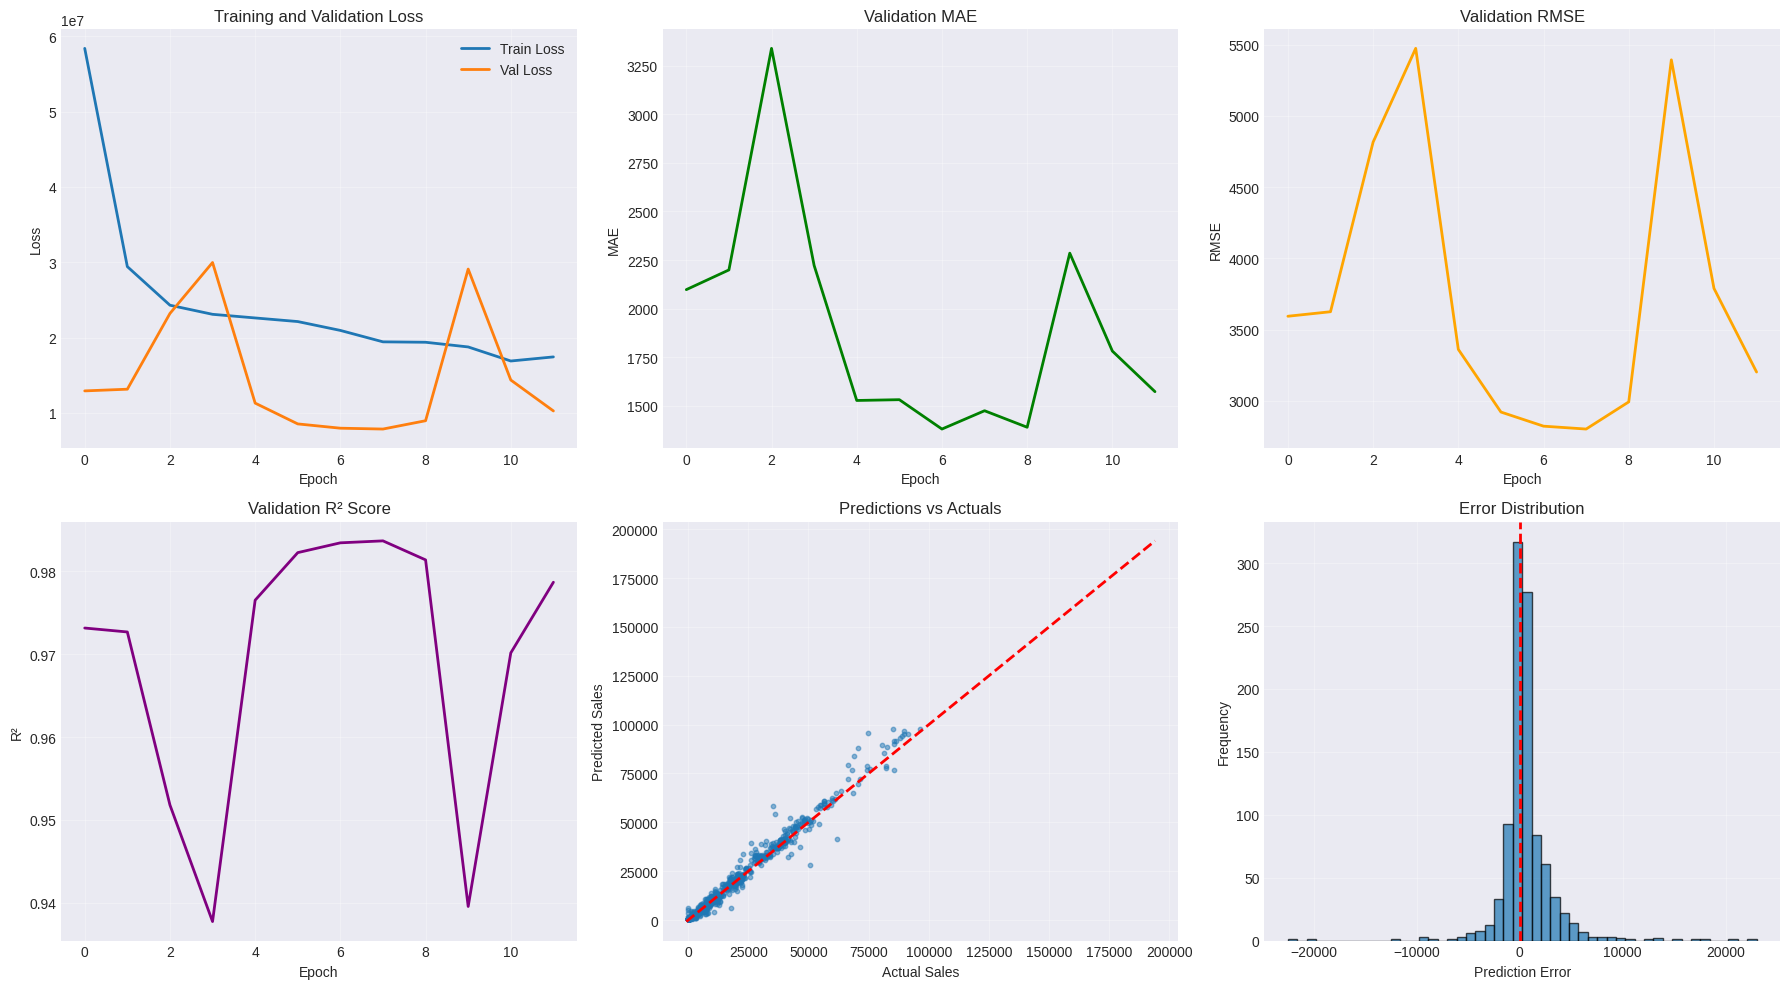

Saved model to patchtst_trained.pt
Saved submission.csv with 115064 rows.


In [6]:
# %% Run training + generate submission (added)
import os
from collections import defaultdict
from datetime import timedelta

# --- 1) Small helper: build patch sequences (single-channel weekly sales) ---
def build_sequences_from_sales(df, lookback, horizon, patch_length):
    """
    df: DataFrame with columns ['Store','Dept','Date','Weekly_Sales']
    returns: sequences (n_samples, n_patches, patch_length, n_features),
             targets (n_samples, ) for horizon==1,
             meta list with (Store, Dept, end_date) for each sample
    """
    n_patches = lookback // patch_length
    sequences = []
    targets = []
    meta = []
    grouped = df.sort_values('Date').groupby(['Store','Dept'])
    for (store,dept), g in grouped:
        sales = g['Weekly_Sales'].values
        dates = g['Date'].values
        L = len(sales)
        # sliding windows
        for start in range(0, L - lookback - horizon + 1):
            seq = sales[start:start+lookback]  # shape (lookback,)
            tgt = sales[start+lookback:start+lookback+horizon]
            # reshape into patches
            seq_reshaped = seq.reshape(n_patches, patch_length, 1)  # n_features=1
            sequences.append(seq_reshaped)
            # horizon==1 -> scalar
            targets.append(float(tgt[0]) if horizon == 1 else tgt.copy())
            meta.append((store, dept, pd.to_datetime(dates[start+lookback-1])))
    if len(sequences) == 0:
        return (np.zeros((0, n_patches, patch_length, 1)), np.zeros((0,)), [])
    return np.stack(sequences), np.array(targets), meta

# --- 2) Prepare data (use original train_df weekly sales) ---
# Use original train_df (not the engineered df) — ensure it exists
if 'train_df' not in globals():
    raise RuntimeError("train_df not found. Make sure you've loaded the training data earlier in the notebook.")

lookback = config.lookback_window  # 52
patch_length = config.patch_length  # 13
horizon = 1  # we'll train one-step model to simplify submission generation
n_patches = lookback // patch_length

print("Building sequences from training data...")
sequences, targets, meta = build_sequences_from_sales(train_df[['Store','Dept','Date','Weekly_Sales']], lookback, horizon, patch_length)
print(f"Built {len(sequences)} training sequences. Sequence shape: {sequences.shape}")

# --- 3) Train/Val split (time-based holdout) ---
if len(sequences) == 0:
    raise RuntimeError("No training sequences created. Check lookback/horizon vs your data length.")

# convert meta to array of end dates
end_dates = np.array([m[2] for m in meta])
max_date = train_df['Date'].max()
val_cutoff = max_date - pd.Timedelta(weeks=16)  # last ~4 months for validation

is_val = end_dates >= val_cutoff
train_idx = np.where(~is_val)[0]
val_idx = np.where(is_val)[0]

# fallback if we don't have val samples
if len(val_idx) == 0:
    # random 10% for val
    rng = np.random.RandomState(config.seed)
    perm = rng.permutation(len(sequences))
    cut = int(len(sequences)*0.9)
    train_idx = perm[:cut]
    val_idx = perm[cut:]

X_train, y_train = sequences[train_idx], targets[train_idx]
X_val, y_val = sequences[val_idx], targets[val_idx]

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")

# --- 4) DataLoaders ---
train_ds = PatchTSTDataset(X_train, y_train, normalize=True)
val_ds = PatchTSTDataset(X_val, y_val, normalize=True)

train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, num_workers=0)

# --- 5) Initialize model (single-channel, one-step forecast) ---
# Overwrite config forecast_horizon to 1 for training/prediction convenience
config.forecast_horizon = 1

n_features = 1
model = EnhancedPatchTSTModel(
    patch_length=patch_length,
    n_patches=n_patches,
    n_features=n_features,
    forecast_horizon=config.forecast_horizon,
    d_model=config.d_model,
    n_heads=config.n_heads,
    n_layers=config.n_layers,
    d_ff=config.d_ff,
    dropout=config.dropout,
    channel_independent=True,
    use_learnable_pos=True
).to(config.device)

# --- 6) Train the model ---
print("Starting training...")
model, train_losses, val_losses, val_metrics = train_patchtst_with_visualization(
    model, train_loader, val_loader, config, num_epochs=config.num_epochs
)

# Save final model weights
torch.save(model.state_dict(), "patchtst_trained.pt")
print("Saved model to patchtst_trained.pt")

# --- 7) Prepare to generate predictions for test set ---
if 'test_df' not in globals():
    raise RuntimeError("test_df not found. Make sure you've loaded the test file earlier in the notebook.")

test_df = test_df.copy()
# ensure Date is datetime
test_df['Date'] = pd.to_datetime(test_df['Date'])

# We'll create a dict of historical sales per (Store,Dept)
hist_sales = defaultdict(list)
hist_dates = defaultdict(list)
grouped_train = train_df.sort_values('Date').groupby(['Store','Dept'])
for (s,d), g in grouped_train:
    hist_sales[(s,d)] = list(g['Weekly_Sales'].values)
    hist_dates[(s,d)] = list(g['Date'].values)

# helper to get last lookback weekly sales for a store-dept (pad with median if necessary)
global_median = train_df['Weekly_Sales'].median()

def get_history_for(store, dept):
    key = (store, dept)
    sales = hist_sales.get(key, []).copy()
    dates = hist_dates.get(key, []).copy()
    # If no history, create constant series with median
    if len(sales) == 0:
        sales = [global_median] * lookback
        last_date = test_df['Date'].min() - pd.Timedelta(weeks=1)
    else:
        last_date = dates[-1]
    # ensure we have at least 'lookback' entries; pad at beginning with median
    if len(sales) < lookback:
        pad = [global_median] * (lookback - len(sales))
        sales = pad + sales
    else:
        sales = sales[-lookback:]
    return sales, last_date

# We'll iterate test rows in chronological order per (Store,Dept) and forecast forward iteratively
submission_preds = []
# If test contains Id, keep it, otherwise create
if 'Id' in test_df.columns:
    id_col = 'Id'
else:
    test_df['Id'] = test_df.apply(lambda r: f"{int(r.Store)}_{int(r.Dept)}_{r.Date.strftime('%Y-%m-%d')}", axis=1)
    id_col = 'Id'

# Group test rows by store-dept and sort dates ascending
for (store,dept), group in test_df.groupby(['Store','Dept']):
    group_sorted = group.sort_values('Date')
    history_sales, last_date = get_history_for(store, dept)
    # maintain a pointer date for where history ends
    cur_last_date = pd.to_datetime(last_date)
    # For each test row, move forward week-by-week by iteratively predicting
    for _, row in group_sorted.iterrows():
        target_date = pd.to_datetime(row['Date'])
        # compute how many weeks ahead we need to step from cur_last_date to target_date
        # If cur_last_date >= target_date -> we already have actuals (rare) -> use last sales value
        weeks_ahead = int(np.round((target_date - cur_last_date) / np.timedelta64(7, 'D')))
        if weeks_ahead <= 0:
            # already covered; take last available real/predicted
            pred = history_sales[-1]
        else:
            # iterate forward weeks_ahead times
            for step in range(weeks_ahead):
                # build sequence from last lookback sales
                seq_arr = np.array(history_sales[-lookback:]).reshape(1, n_patches, patch_length, 1).astype(np.float32)
                seq_tensor = torch.FloatTensor(seq_arr).to(config.device)
                # normalize using dataset normalization logic: use dataset mean/std computed previously
                # we'll reuse train_ds mean/std for normalization if available
                if hasattr(train_ds, 'mean'):
                    seq_shape = seq_tensor.shape
                    flat = seq_tensor.reshape(seq_shape[0], -1)
                    flat = (flat - train_ds.mean.to(config.device)) / train_ds.std.to(config.device)
                    seq_tensor = flat.reshape(seq_shape)
                model.eval()
                with torch.no_grad():
                    out = model(seq_tensor).detach().cpu().numpy().ravel()
                # out is array length 1 (forecast_horizon==1)
                next_pred = float(out[0])
                # append predicted week to history (used for next steps)
                history_sales.append(next_pred)
                # move cur_last_date forward 1 week
                cur_last_date = cur_last_date + pd.Timedelta(weeks=1)
            # after iterating, the last appended value corresponds to target_date
            pred = history_sales[-1]
        submission_preds.append((row[id_col], pred))

# Build submission DataFrame and save
sub_df = pd.DataFrame(submission_preds, columns=[id_col, 'Weekly_Sales'])
# Keep ordering same as test_df
sub_df = test_df[[id_col]].merge(sub_df, on=id_col, how='left')
sub_df.to_csv('submission.csv', index=False)
print("Saved submission.csv with", len(sub_df), "rows.")

KeyboardInterrupt: 